In [1]:
import pandas as pd 
df = pd.read_csv('../data/us_congressional_record/us_congress_speeches_processed.csv')
df = df.sample(n=50000, random_state = 42)
df

,Unnamed: 0,doc,party,speech_year,doc_clean
691903,691903,"Speaker, I would like to express my strong su...",Republican,2005,like express support convey land use heliport ...
351367,351367,"Speaker, this bill, H R. 2277 authorizes $75,...",Democrat,1979,bill authorize airport airway trust fund year ...
250310,250310,"Speaker, I appreciate having this opportunity...",Democrat,1972,appreciate have opportunity discuss colleague ...
644446,644446,The gentleman is absolutely correct. I rememb...,Democrat,2000,gentleman remember friend say start road life ...
803736,803736,I thank the gentleman from Florida for some o...,Republican,2002,thank gentleman opportunity share passion view...
...,...,...,...,...,...
79650,79650,"Chairman, I rise in opposition to the amendme...",Democrat,1958,rise opposition amendment offer gentleman answ...
544086,544086,"Speaker, there is one central question that m...",Republican,1993,question answer people issue health care trust...
856936,856936,"Speaker, I very much appreciate the gentleman...",Republican,2003,appreciate gentleman come discuss tonight brin...
811229,811229,"Chairman, will the gentlewoman yield? Chairm...",Democrat,1997,gentlewoman yield like reemphasize gentlewoman...


In [2]:
import sys
sys.path.append('../gtm/')
from corpus import GTMCorpus
from gtm import GTM

# Create a GTMCorpus object
train_dataset = GTMCorpus(
    df, 
    prevalence = "~ party*C(speech_year)", 
    content = "~ party*C(speech_year)"
)

train_dataset.M_prevalence_covariates.shape

/home/germain/Documents/topic models/generalized_topic_model/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(50000, 188)

In [3]:
train_dataset.M_prevalence_covariates

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
train_dataset.prevalence_colnames

['Intercept',
 'party[T.Republican]',
 'C(speech_year)[T.1921]',
 'C(speech_year)[T.1922]',
 'C(speech_year)[T.1923]',
 'C(speech_year)[T.1924]',
 'C(speech_year)[T.1925]',
 'C(speech_year)[T.1926]',
 'C(speech_year)[T.1928]',
 'C(speech_year)[T.1929]',
 'C(speech_year)[T.1930]',
 'C(speech_year)[T.1931]',
 'C(speech_year)[T.1932]',
 'C(speech_year)[T.1933]',
 'C(speech_year)[T.1934]',
 'C(speech_year)[T.1935]',
 'C(speech_year)[T.1936]',
 'C(speech_year)[T.1937]',
 'C(speech_year)[T.1938]',
 'C(speech_year)[T.1939]',
 'C(speech_year)[T.1940]',
 'C(speech_year)[T.1941]',
 'C(speech_year)[T.1942]',
 'C(speech_year)[T.1943]',
 'C(speech_year)[T.1944]',
 'C(speech_year)[T.1945]',
 'C(speech_year)[T.1946]',
 'C(speech_year)[T.1947]',
 'C(speech_year)[T.1948]',
 'C(speech_year)[T.1949]',
 'C(speech_year)[T.1950]',
 'C(speech_year)[T.1951]',
 'C(speech_year)[T.1952]',
 'C(speech_year)[T.1953]',
 'C(speech_year)[T.1954]',
 'C(speech_year)[T.1955]',
 'C(speech_year)[T.1956]',
 'C(speech_year)[

In [5]:
# Train the model
tm = GTM(
    train_dataset, 
    n_topics=50,
    doc_topic_prior='dirichlet',
    alpha=0.1,
    prevalence_covariates_regularization=0.1,
    update_prior=True,
    encoder_hidden_layers=[], # structure of the encoder neural net
    decoder_hidden_layers=[300], # structure of the decoder neural net
    num_epochs=5,
    print_every=10000,
    log_every=1,
    w_prior=None,
    batch_size=250
)


Epoch   1	Mean Training Loss:14.3595090

['bill', 'year', 'go', 'gentleman', 'make', 'time', 'say', 'people']
['time', 'bill', 'year', 'go', 'people', 'make', 'gentleman', 'say']
['bill', 'year', 'make', 'go', 'gentleman', 'time', 'say', 'people']
['bill', 'year', 'time', 'gentleman', 'go', 'make', 'people', 'say']
['bill', 'amendment', 'committee', 'gentleman', 'year', 'time', 'make', 'legislation']
['bill', 'year', 'program', 'go', 'make', 'time', 'people', 'need']
['bill', 'year', 'time', 'say', 'make', 'gentleman', 'go', 'people']
['bill', 'year', 'go', 'gentleman', 'time', 'say', 'people', 'make']
['bill', 'year', 'time', 'gentleman', 'go', 'make', 'people', 'say']
['go', 'people', 'say', 'get', 'year', 'want', 'tax', 'make']
['bill', 'year', 'go', 'time', 'make', 'gentleman', 'say', 'people']
['say', 'go', 'bill', 'year', 'people', 'time', 'make', 'gentleman']
['bill', 'year', 'time', 'make', 'go', 'support', 'people', 'say']
['go', 'bill', 'say', 'year', 'gentleman', 'make', 't


Epoch   2	Mean Training Loss:4.0668396

['gentleman', 'amendment', 'yield', 'rule', 'committee', 'member', 'think', 'say']
['bill', 'year', 'program', 'time', 'make', 'need', 'amendment', 'support']
['gentleman', 'amendment', 'say', 'think', 'yield', 'time', 'member', 'bill']
['gentleman', 'say', 'know', 'member', 'think', 'time', 'yield', 'people']
['amendment', 'committee', 'consideration', 'rule', 'bill', 'appropriation', 'conference', 'authorization']
['program', 'percent', 'cost', 'increase', 'price', 'provide', 'year', 'bill']
['gentleman', 'say', 'think', 'amendment', 'time', 'yield', 'member', 'go']
['bill', 'amendment', 'legislation', 'support', 'member', 'consideration', 'committee', 'report']
['gentleman', 'amendment', 'bill', 'yield', 'think', 'say', 'time', 'rule']
['tax', 'go', 'taxis', 'get', 'cut', 'budget', 'talk', 'senior']
['gentleman', 'amendment', 'yield', 'rule', 'committee', 'bill', 'think', 'vote']
['go', 'say', 'get', 'want', 'talk', 'people', 'think', 'thing'


Epoch   3	Mean Training Loss:3.7513986

['gentleman', 'yield', 'rule', 'consent', 'tempore', 'motion', 'minute', 'amendment']
['bill', 'program', 'amendment', 'provide', 'increase', 'need', 'health', 'fund']
['gentleman', 'yield', 'amendment', 'think', 'committee', 'rule', 'question', 'vote']
['tribute', 'friend', 'honor', 'gentleman', 'man', 'serve', 'thank', 'miss']
['rule', 'amendment', 'appropriation', 'conference', 'authorization', 'bill', 'consideration', 'committee']
['percent', 'increase', 'cost', 'price', 'program', 'income', 'market', 'tax']
['gentleman', 'yield', 'think', 'say', 'thank', 'friend', 'member', 'know']
['legislation', 'urge', 'amend', 'consume', 'support', 'passage', 'consideration', 'rule']
['gentleman', 'amendment', 'yield', 'rule', 'committee', 'bill', 'vote', 'think']
['tax', 'go', 'taxis', 'get', 'cut', 'debt', 'senior', 'kid']
['gentleman', 'rule', 'amendment', 'motion', 'yield', 'consent', 'tempore', 'minute']
['go', 'get', 'say', 'talk', 'think', 'tax',


Epoch   4	Mean Training Loss:3.5452088

['gentleman', 'noon', 'consent', 'tempore', 'reconsider', 'yield', 'quorum', 'thereto']
['bill', 'amendment', 'provision', 'health', 'funding', 'fund', 'provide', 'cost']
['gentleman', 'yield', 'amendment', 'tempore', 'consent', 'thank', 'think', 'minute']
['tribute', 'honor', 'passing', 'sympathy', 'miss', 'friend', 'friendship', 'serve']
['rule', 'appropriation', 'authorization', 'bill', 'conference', 'consideration', 'committee', 'waive']
['percent', 'cost', 'income', 'increase', 'program', 'tax', 'price', 'market']
['gentleman', 'friend', 'honor', 'tribute', 'thank', 'man', 'love', 'miss']
['designate', 'amend', 'passage', 'legislation', 'consume', 'honor', 'veteran', 'reconsider']
['gentleman', 'amendment', 'yield', 'tempore', 'bill', 'motion', 'appropriation', 'minute']
['tax', 'taxis', 'go', 'cut', 'get', 'money', 'debt', 'deficit']
['motion', 'rule', 'tempore', 'noon', 'thereto', 'minute', 'amendment', 'gentleman']
['get', 'go', 'talk', 


Epoch   5	Mean Training Loss:3.4707596

['noon', 'adjourn', 'gentleman', 'quorum', 'consent', 'nay', 'tempore', 'yield']
['bill', 'amendment', 'provision', 'insurance', 'health', 'rule', 'drug', 'vote']
['gentleman', 'yield', 'consent', 'tempore', 'amendment', 'thank', 'quorum', 'gentlewoman']
['tribute', 'passing', 'honor', 'sympathy', 'miss', 'serve', 'friend', 'friendship']
['authorization', 'waive', 'rule', 'committee', 'appropriation', 'conference', 'bill', 'consideration']
['percent', 'cost', 'income', 'program', 'increase', 'price', 'market', 'tax']
['love', 'man', 'honor', 'friendship', 'tribute', 'hero', 'wife', 'memory']
['amend', 'designate', 'passage', 'legislation', 'reconsider', 'urge', 'consume', 'veteran']
['amendment', 'gentleman', 'funding', 'fund', 'cut', 'bill', 'appropriation', 'budget']
['tax', 'taxis', 'go', 'cut', 'get', 'money', 'borrow', 'checkbook']
['motion', 'noon', 'adjourn', 'rule', 'nay', 'tempore', 'vote', 'aye']
['wage', 'get', 'talk', 'buy', 'go', 'g

In [26]:
# Assess the quality of the learned word embeddings 
# Top 8 closest words to a specific word

import torch
import torch.nn.functional as F

specific_word = 'terrorist'

word_id = [i for i,w in enumerate(train_dataset.vocab) if w == specific_word][0]

words = tm.AutoEncoder.decoder['dec_1'].weight.T

logit = torch.matmul(words.T[word_id], words)

beta = F.softmax(logit)

tm.AutoEncoder.eval()
topic_words = []
vals, indices = torch.topk(beta, 8)
vals = vals.cpu().tolist()
indices = indices.cpu().tolist()
[tm.id2token[idx] for idx in indices]

/tmp/ipykernel_26097/3811166158.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  beta = F.softmax(logit)


['terrorist',
 'terrorism',
 'terror',
 'murder',
 'bless',
 'hero',
 '11th',
 'bravery']

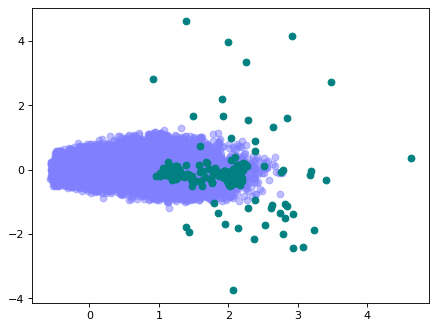

In [7]:
# Visualize the learned embeddings space 

# Topic, covariates, and word embeddings
topics_and_covs = tm.AutoEncoder.decoder['dec_0'].weight.T
words = tm.AutoEncoder.decoder['dec_1'].weight.T

# Dimension reduction (PCA 50 components + UMAP 2 components)
all_vecs = torch.cat([words.T, topics_and_covs], dim=0)
all_vecs = all_vecs.cpu().detach().numpy()

#from sklearn.preprocessing import normalize
#all_vecs = normalize(all_vecs.cpu().detach().numpy(), axis=1, norm='l1')

from sklearn.decomposition import PCA
pca_args={"n_components": 2, "svd_solver": "full"}
pca_model = PCA(**pca_args).fit(all_vecs)
all_vecs = pca_model.transform(all_vecs)

#import umap
#umap_args={"n_neighbors": 15, "n_components": 2, "random_state": 0}
#umap_model = umap.umap_.UMAP(**umap_args).fit(all_vecs)

# Plot resulting vectors
import matplotlib.pyplot as plt
plt.figure(dpi=80)

words = words.T.cpu().detach().numpy()
words = pca_model.transform(words)
#words = umap_model.transform(words)
plt.scatter(
    words[:,0],
    words[:,1],
    color=(0.5, 0.5, 1),
    alpha=0.5,
)

topics = topics_and_covs.cpu().detach().numpy()
topics = pca_model.transform(topics)
#topics = umap_model.transform(topics)
plt.scatter(
    topics[:,0],
    topics[:,1],
    color=(0, 0.5, 0.5),
    alpha=1,
)